# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [5]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [6]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [7]:
img_height=299
img_width=299
batch_size=64

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [9]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [11]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [12]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [13]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


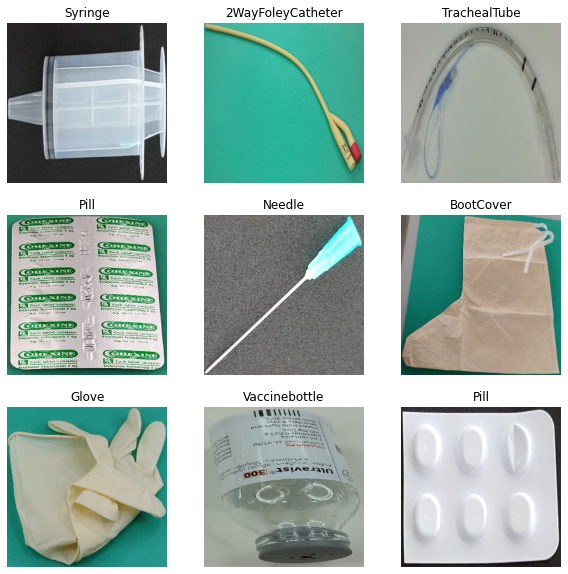

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [16]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [18]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [19]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
#custom_inceptionv3_model.trainable = True
#for layer in custom_inceptionv3_model.layers:
#    layer.trainable = True
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


# Fitting

In [34]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/'

In [22]:
EPOCHS = 4000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/4000
49/49 [==============================] - 72s 731ms/step - loss: 1.0545 - accuracy: 0.7137 - val_loss: 4.0245 - val_accuracy: 0.0828
Epoch 2/4000
49/49 [==============================] - 26s 537ms/step - loss: 0.3295 - accuracy: 0.8953 - val_loss: 3.2971 - val_accuracy: 0.3545
Epoch 3/4000
49/49 [==============================] - 26s 539ms/step - loss: 0.1925 - accuracy: 0.9451 - val_loss: 2.8978 - val_accuracy: 0.5084
Epoch 4/4000
49/49 [==============================] - 26s 539ms/step - loss: 0.1212 - accuracy: 0.9596 - val_loss: 7.1599 - val_accuracy: 0.2561
Epoch 5/4000
49/49 [==============================] - 26s 539ms/step - loss: 0.1106 - accuracy: 0.9677 - val_loss: 2.3610 - val_accuracy: 0.5912
Epoch 6/4000
49/49 [==============================] - 26s 539ms/step - loss: 0.1366 - accuracy: 0.9632 - val_loss: 1.3371 - val_accuracy: 0.7012
Epoch 7/4000
49/49 [==============================] - 26s 539ms/step - loss: 0.0920 - accuracy: 0.9758 - val_loss: 1.2955 - val_ac

Text(0.5, 1.0, 'Training and Validation Accuracy')

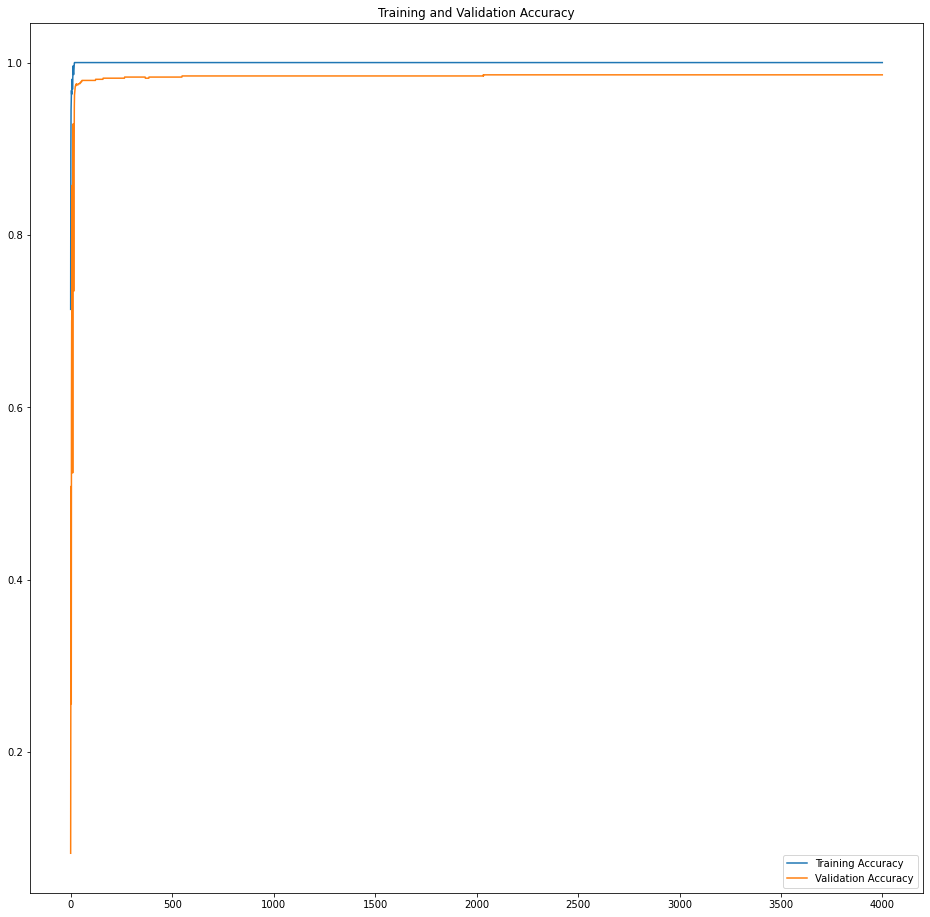

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


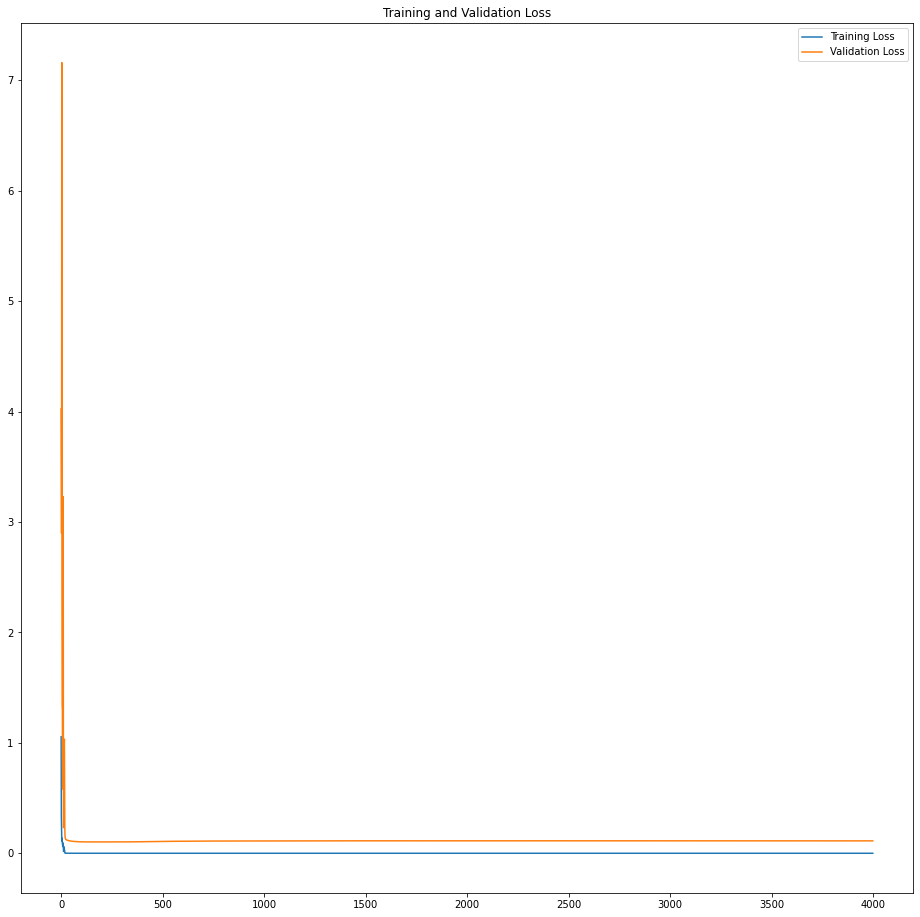

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 355ms/step - loss: 3.3870 - accuracy: 0.5563
test_indoor_ds_results:test loss, test acc: [3.38704252243042, 0.5562987923622131]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 455ms/step - loss: 4.0883 - accuracy: 0.5608
test_outdoor_ds_results:test loss, test acc: [4.088315963745117, 0.5608280301094055]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 222ms/step - loss: 1.3840 - accuracy: 0.7856
test_belt_ds_results:test loss, test acc: [1.3840436935424805, 0.7855847477912903]


In [3]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc0.98.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_NoFreezExtractorOurOutputLayer(LongEP)-NoClassImbalanc

# Testing in testset

In [22]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 144ms/step - loss: 1.2757 - accuracy: 0.7439
Epoch040 
 test_indoor_acc=0.46934226155281067 
 test_outdoor_acc=0.4971337616443634 
 test_belt_acc=0.7438803315162659
35/35 [==============================] - 5s 145ms/step - loss: 1.2772 - accuracy: 0.7575
Epoch080 
 test_indoor_acc=0.47881829738616943 
 test_outdoor_acc=0.5108280181884766 
 test_belt_acc=0.7574796080589294
35/35 [==============================] - 5s 142ms/step - loss: 1.2941 - accuracy: 0.7620
Epoch120 
 test_indoor_acc=0.4843924045562744 
 test_outdoor_acc=0.5254777073860168 
 test_belt_acc=0.7620127201080322
35/35 [==============================] - 5s 144ms/step - loss: 1.3017 - accuracy: 0.7638
Epoch160 
 test_indoor_acc=0.48494982719421387 
 test_outdoor_acc=0.5270700454711914 
 test_belt_acc=0.7638259530067444
35/35 [==============================] - 5s 147ms/step - loss: 1.3052 - accuracy: 0.7643
Epoch200 
 test_indoor_acc=0.4871794879436493 
 test_outdoor_acc=0.529936313

In [23]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)

range(40, 4040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

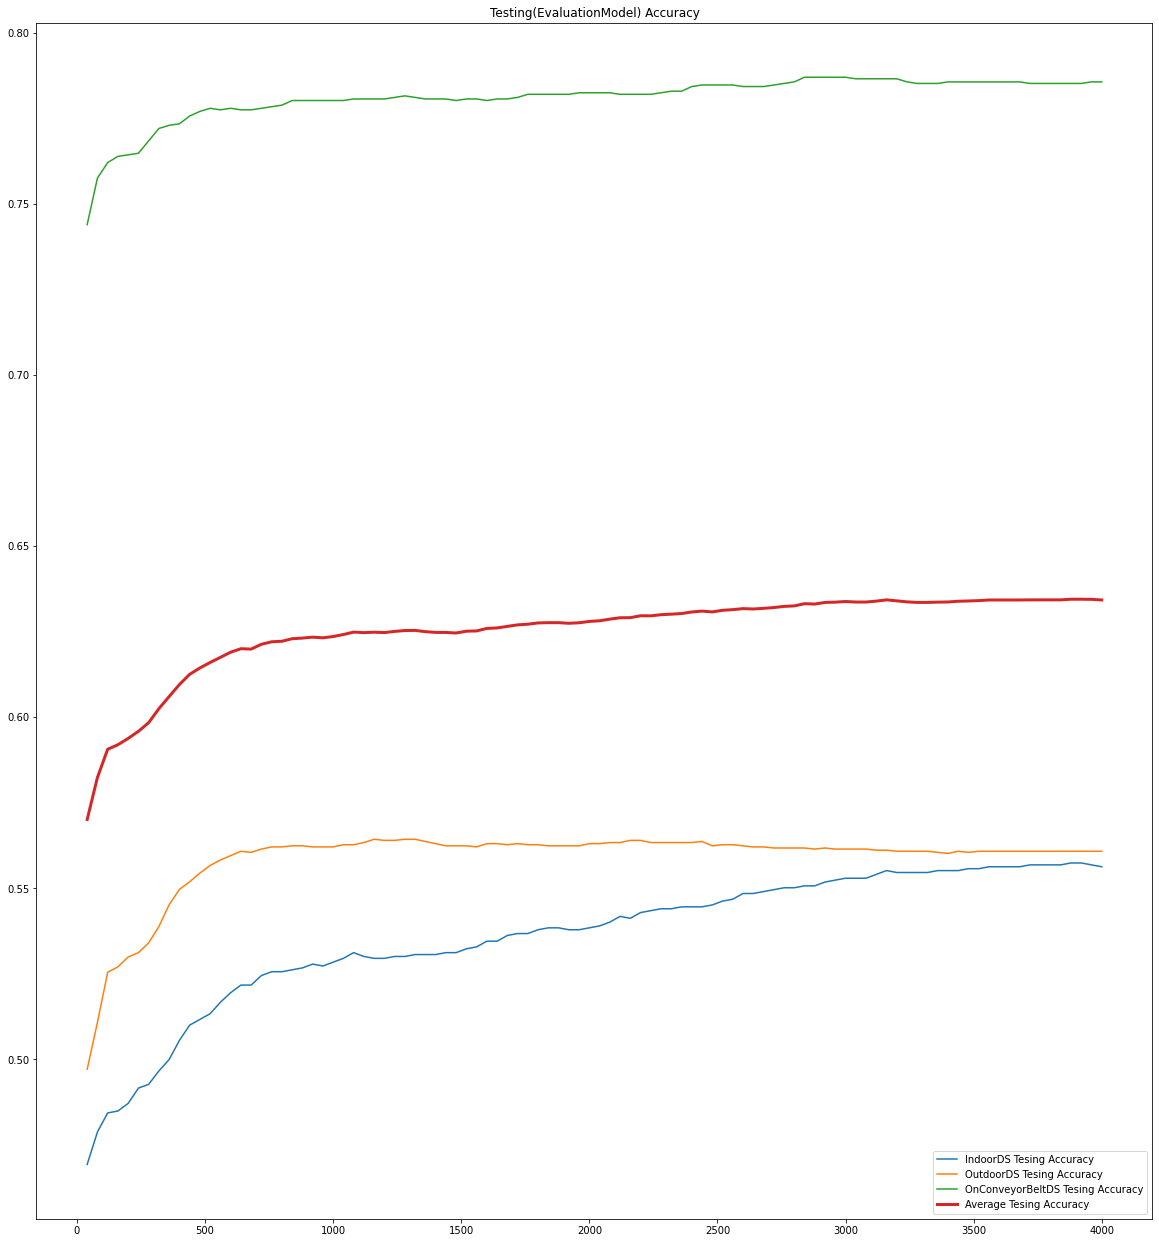

In [25]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [26]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.6344576875368754
max index -> 96
The [Epoch] of max acc -> 3880


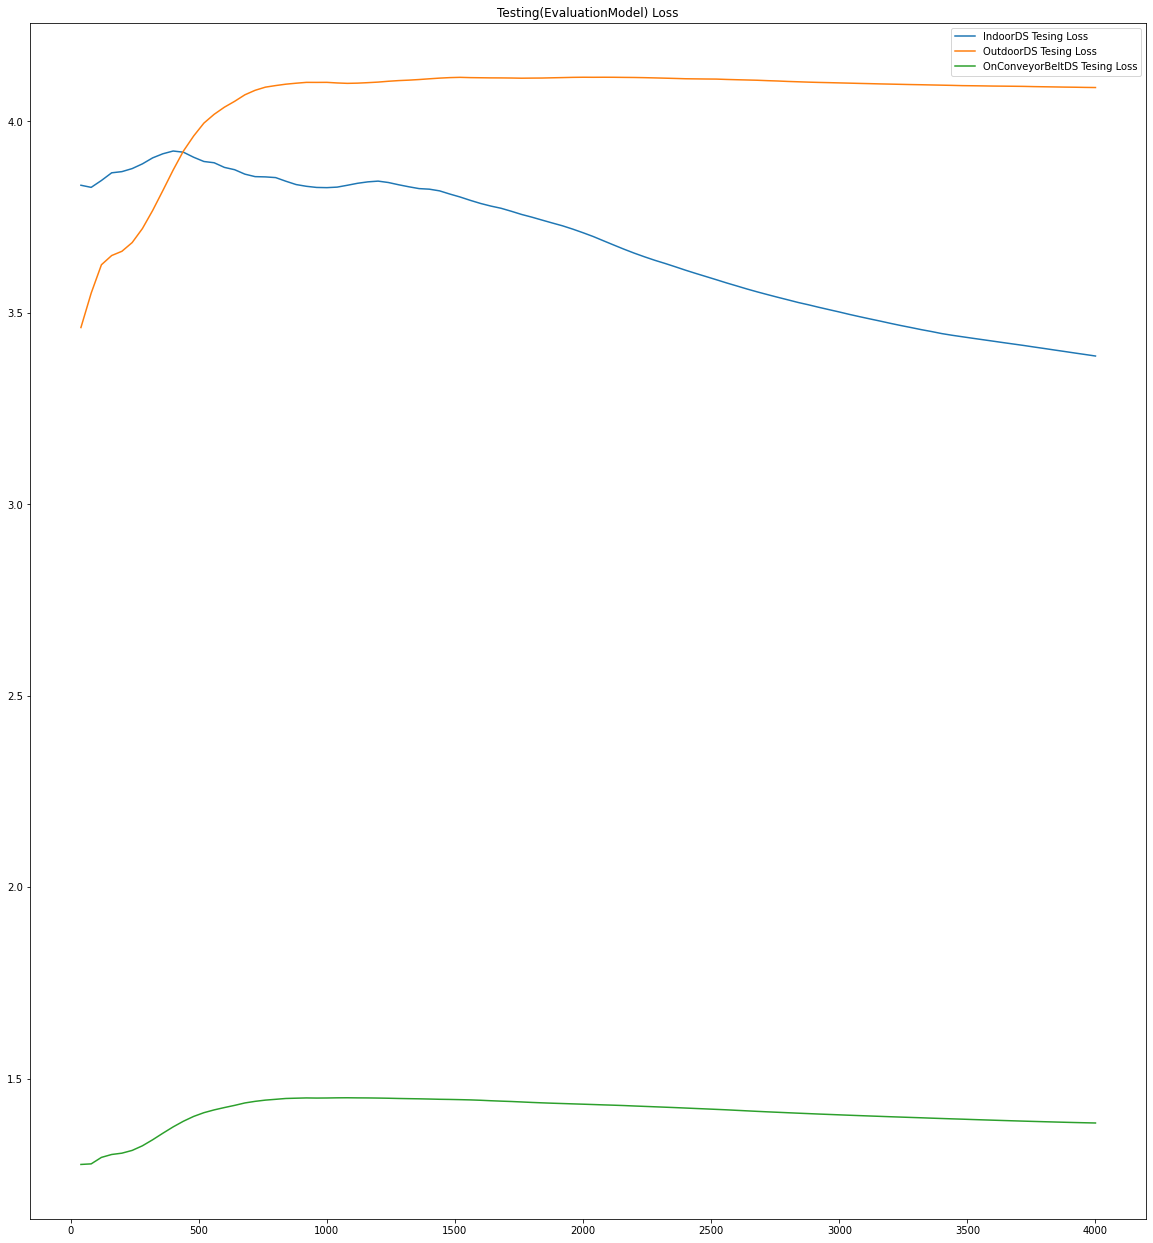

In [27]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [28]:
test_indoor_acc

[0.46934226155281067,
 0.47881829738616943,
 0.4843924045562744,
 0.48494982719421387,
 0.4871794879436493,
 0.49163880944252014,
 0.49275362491607666,
 0.49665552377700806,
 0.5,
 0.505574107170105,
 0.5100334286689758,
 0.5117056965827942,
 0.5133779048919678,
 0.5167223811149597,
 0.519509494304657,
 0.52173912525177,
 0.52173912525177,
 0.5245261788368225,
 0.5256410241127014,
 0.5256410241127014,
 0.5261984467506409,
 0.5267558693885803,
 0.5278706550598145,
 0.5273132920265198,
 0.5284280776977539,
 0.5295429229736328,
 0.5312151908874512,
 0.5301003456115723,
 0.5295429229736328,
 0.5295429229736328,
 0.5301003456115723,
 0.5301003456115723,
 0.5306577682495117,
 0.5306577682495117,
 0.5306577682495117,
 0.5312151908874512,
 0.5312151908874512,
 0.5323299765586853,
 0.5328873991966248,
 0.5345596671104431,
 0.5345596671104431,
 0.5362318754196167,
 0.5367892980575562,
 0.5367892980575562,
 0.5379041433334351,
 0.5384615659713745,
 0.5384615659713745,
 0.5379041433334351,
 0.5379

In [29]:
test_outdoor_acc

[0.4971337616443634,
 0.5108280181884766,
 0.5254777073860168,
 0.5270700454711914,
 0.5299363136291504,
 0.53121018409729,
 0.534076452255249,
 0.5388535261154175,
 0.5452229380607605,
 0.549681544303894,
 0.5519108176231384,
 0.5544586181640625,
 0.5566878914833069,
 0.5582802295684814,
 0.5595541596412659,
 0.5608280301094055,
 0.5605095624923706,
 0.5614649653434753,
 0.5621019005775452,
 0.5621019005775452,
 0.5624203681945801,
 0.5624203681945801,
 0.5621019005775452,
 0.5621019005775452,
 0.5621019005775452,
 0.562738835811615,
 0.562738835811615,
 0.5633757710456848,
 0.5643312335014343,
 0.5640127658843994,
 0.5640127658843994,
 0.5643312335014343,
 0.5643312335014343,
 0.5636942386627197,
 0.5630573034286499,
 0.5624203681945801,
 0.5624203681945801,
 0.5624203681945801,
 0.5621019005775452,
 0.5630573034286499,
 0.5630573034286499,
 0.562738835811615,
 0.5630573034286499,
 0.562738835811615,
 0.562738835811615,
 0.5624203681945801,
 0.5624203681945801,
 0.5624203681945801,
 

In [30]:
test_belt_acc

[0.7438803315162659,
 0.7574796080589294,
 0.7620127201080322,
 0.7638259530067444,
 0.7642792463302612,
 0.7647325396537781,
 0.7683590054512024,
 0.7719854712486267,
 0.7728921175003052,
 0.773345410823822,
 0.7756119966506958,
 0.7769718766212463,
 0.7778785228729248,
 0.777425229549408,
 0.7778785228729248,
 0.777425229549408,
 0.777425229549408,
 0.7778785228729248,
 0.7783318161964417,
 0.7787851095199585,
 0.7801450490951538,
 0.7801450490951538,
 0.7801450490951538,
 0.7801450490951538,
 0.7801450490951538,
 0.7801450490951538,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7810516953468323,
 0.7815049886703491,
 0.7810516953468323,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7801450490951538,
 0.7805983424186707,
 0.7805983424186707,
 0.7801450490951538,
 0.7805983424186707,
 0.7805983424186707,
 0.7810516953468323,
 0.781958281993866,
 0.781958281993866,
 0.781958281993866,
 0.781958281993866,
 0.781958281993866,
 

In [31]:
test_indoor_loss

[3.832930564880371,
 3.82741117477417,
 3.8453612327575684,
 3.8654234409332275,
 3.868501901626587,
 3.8764498233795166,
 3.8887739181518555,
 3.904444456100464,
 3.915148973464966,
 3.922311782836914,
 3.9192419052124023,
 3.906036138534546,
 3.8949759006500244,
 3.891671895980835,
 3.8795554637908936,
 3.8735146522521973,
 3.8619158267974854,
 3.8554201126098633,
 3.8547589778900146,
 3.852916955947876,
 3.843412160873413,
 3.834721088409424,
 3.830191135406494,
 3.827204704284668,
 3.8266637325286865,
 3.8280398845672607,
 3.8328847885131836,
 3.838088274002075,
 3.841785192489624,
 3.8437130451202393,
 3.8400917053222656,
 3.8342185020446777,
 3.828913688659668,
 3.8241655826568604,
 3.822669744491577,
 3.818265438079834,
 3.8099312782287598,
 3.802244186401367,
 3.793466567993164,
 3.7853734493255615,
 3.7785491943359375,
 3.77278995513916,
 3.764975070953369,
 3.7566723823547363,
 3.7496306896209717,
 3.7419307231903076,
 3.734346389770508,
 3.7269487380981445,
 3.71830248832702

In [32]:
test_outdoor_loss

[3.4613401889801025,
 3.55112361907959,
 3.6252992153167725,
 3.649379253387451,
 3.660491466522217,
 3.6832432746887207,
 3.7198004722595215,
 3.767086982727051,
 3.8193113803863525,
 3.872652292251587,
 3.9221858978271484,
 3.9615564346313477,
 3.9952244758605957,
 4.018189430236816,
 4.036786079406738,
 4.05211877822876,
 4.0691728591918945,
 4.080915451049805,
 4.089122295379639,
 4.0932488441467285,
 4.096893310546875,
 4.099421977996826,
 4.101598739624023,
 4.101525783538818,
 4.101649761199951,
 4.100070476531982,
 4.099031925201416,
 4.0996012687683105,
 4.1008687019348145,
 4.102318286895752,
 4.104501724243164,
 4.106233596801758,
 4.107433319091797,
 4.109009742736816,
 4.110934257507324,
 4.112707138061523,
 4.114025592803955,
 4.11472749710083,
 4.1139960289001465,
 4.1136603355407715,
 4.113324165344238,
 4.113236904144287,
 4.112962245941162,
 4.112499237060547,
 4.112764835357666,
 4.1129302978515625,
 4.113536834716797,
 4.1140875816345215,
 4.114705562591553,
 4.1150

In [33]:
test_belt_loss

[1.275730013847351,
 1.277206301689148,
 1.2941292524337769,
 1.3017226457595825,
 1.3051683902740479,
 1.3123633861541748,
 1.3244186639785767,
 1.340185523033142,
 1.3573216199874878,
 1.3738123178482056,
 1.388566493988037,
 1.401134729385376,
 1.4108974933624268,
 1.4181748628616333,
 1.42428719997406,
 1.4300004243850708,
 1.4363195896148682,
 1.440510869026184,
 1.443711519241333,
 1.445817232131958,
 1.4480077028274536,
 1.4487358331680298,
 1.4494065046310425,
 1.4490671157836914,
 1.4492706060409546,
 1.4496891498565674,
 1.4498387575149536,
 1.4495545625686646,
 1.4494116306304932,
 1.4490679502487183,
 1.4486137628555298,
 1.4479975700378418,
 1.4475141763687134,
 1.4470959901809692,
 1.4465266466140747,
 1.4458881616592407,
 1.4454841613769531,
 1.444922685623169,
 1.4442811012268066,
 1.4433283805847168,
 1.4420886039733887,
 1.4410464763641357,
 1.4400980472564697,
 1.4389073848724365,
 1.4376640319824219,
 1.4365947246551514,
 1.435632586479187,
 1.4347808361053467,
 1.4

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [35]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch3880-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

N = 100

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)} are predicting")
x_indoor_sets = np.array_split(x_test_indoor, N)
del x_test_indoor
y_all_sets_predicted = []
for x in x_indoor_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_indoor_predicted = np.concatenate(y_all_sets_predicted)
del x_indoor_sets,test_indoor_ds

x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)} are predicting")
x_outdoor_sets = np.array_split(x_test_outdoor, N)
del x_test_outdoor
y_all_sets_predicted = []
for x in x_outdoor_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_outdoor_predicted = np.concatenate(y_all_sets_predicted)
del x_outdoor_sets,test_outdoor_ds

x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)} are predicting")
x_belt_sets = np.array_split(x_test_belt, N)
del x_test_belt
y_all_sets_predicted = []
for x in x_belt_sets:
  y_all_sets_predicted.append(last_epoch_model.predict(x,batch_size=batch_size))
y_belt_predicted = np.concatenate(y_all_sets_predicted)
del x_belt_sets,test_belt_ds

y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
y_all_predicted = np.concatenate([y_indoor_predicted,y_outdoor_predicted,y_belt_predicted],axis=0)
print(f"all num x,y :{len(y_all_predicted)},{len(y_all)}")

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794 are predicting
train_outdoor num x,y : 3140,3140 are predicting
train_belt num x,y : 2206,2206 are predicting
all num x,y :7140,7140


In [36]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4493
FP=2647
acc=0.6292717086834734
all check = 7140


In [37]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 50.86206896551724%
2WayConnectorforFoley acc = 84.35374149659864%
2WayFoleyCatheter acc = 41.04477611940299%
3WayConnectorforFoley acc = 82.90598290598291%
3Waystopcock acc = 94.5945945945946%
AlcoholBottle acc = 81.25%
AlcoholPad acc = 35.714285714285715%
BootCover acc = 64.45783132530121%
CottonBall acc = 97.0059880239521%
CottonSwap acc = 51.048951048951054%
Dilator acc = 62.39316239316239%
DisposableInfusionSet acc = 53.09734513274337%
ExtensionTube acc = 30.081300813008134%
FaceShield acc = 41.9753086419753%
FrontLoadSyringe acc = 11.504424778761061%
GauzePad acc = 44.88636363636363%
Glove acc = 63.69047619047619%
GuideWire acc = 21.428571428571427%
LiquidBottle acc = 43.89312977099237%
Mask acc = 89.87012987012987%
NGTube acc = 31.61290322580645%
NasalCannula acc = 29.20353982300885%
Needle acc = 73.57142857142858%
OxygenMask acc = 47.368421052631575%
PPESuit acc = 87.90322580645162%
PharmaceuticalProduct acc = 75.46728971962617%
Pill acc = 94.53781512

In [38]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 59,   1,   0, ...,   0,   0,   0],
       [  0, 124,   0, ...,   0,   0,   0],
       [  0,   0,  55, ...,   0,   0,   1],
       ...,
       [  0,   0,   0, ...,  36,   1,   0],
       [  0,   0,   2, ...,   0, 152,   0],
       [  0,   0,   5, ...,   0,   0,  59]], dtype=int64)

In [39]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[50.86206897,  0.86206897,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 84.3537415 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 41.04477612, ...,  0.        ,
         0.        ,  0.74626866],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 30.        ,
         0.83333333,  0.        ],
       [ 0.        ,  0.        ,  0.93896714, ...,  0.        ,
        71.36150235,  0.        ],
       [ 0.        ,  0.        ,  4.38596491, ...,  0.        ,
         0.        , 51.75438596]])

<AxesSubplot:>

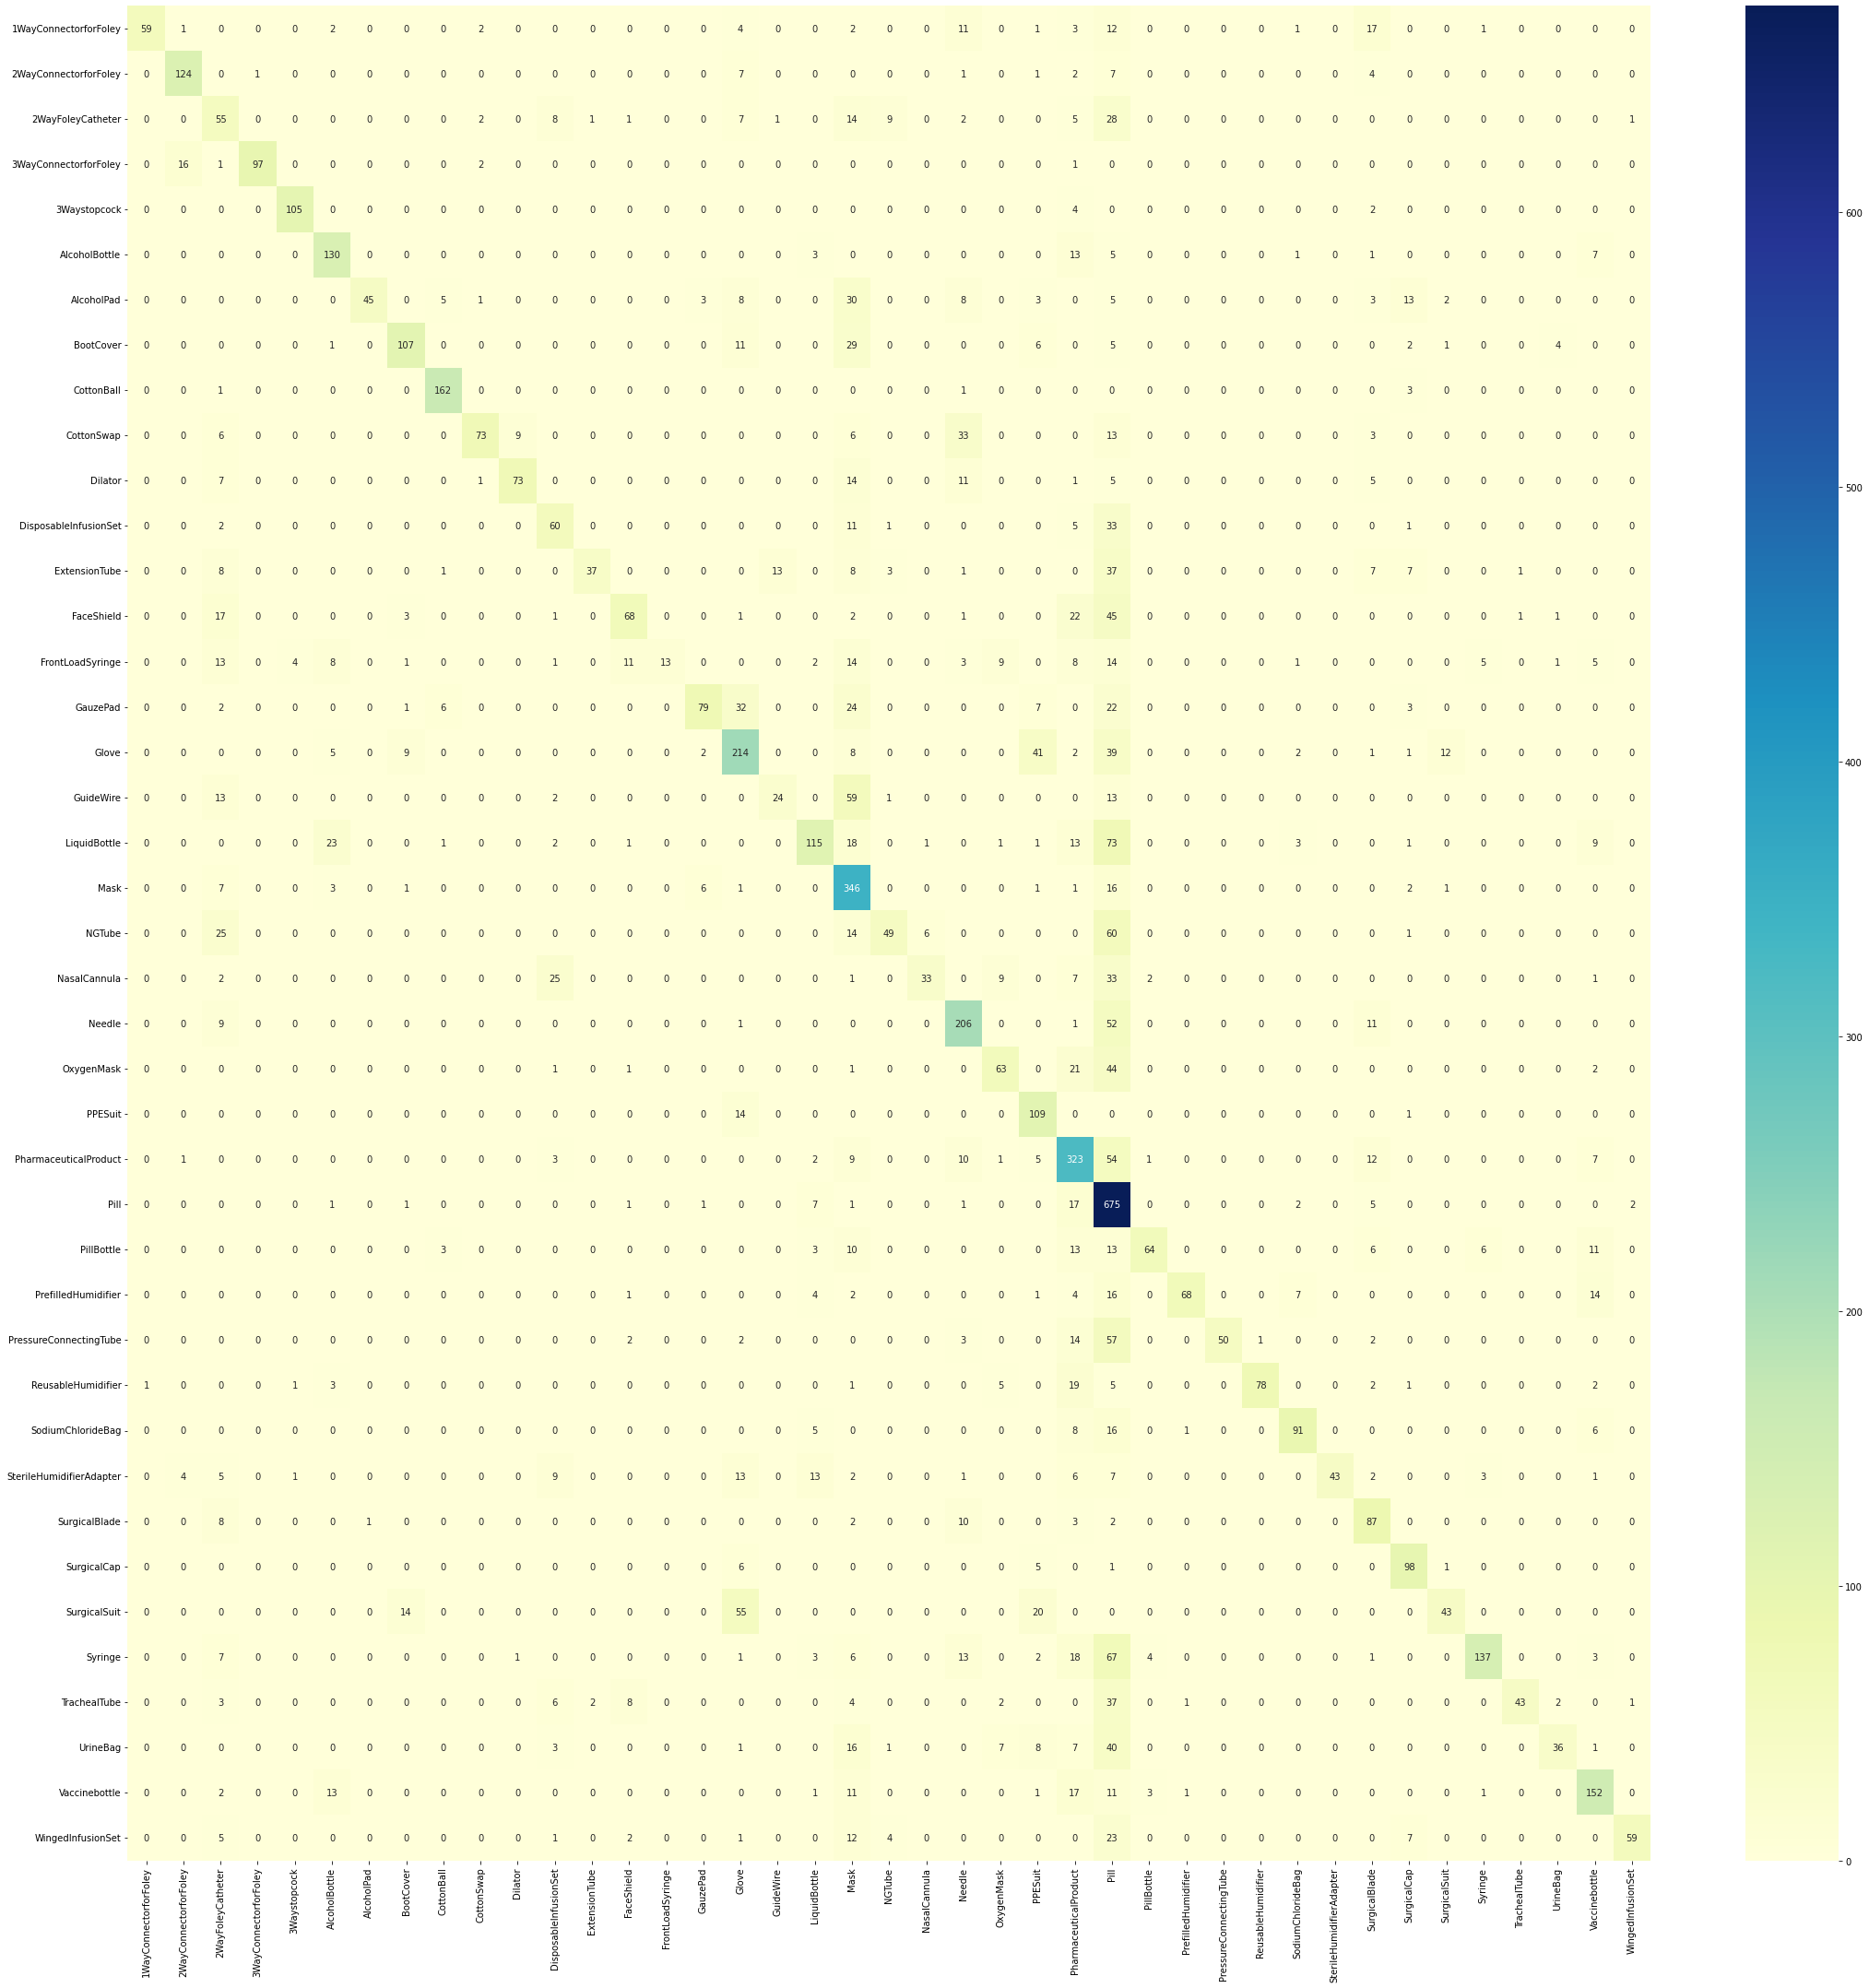

In [40]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

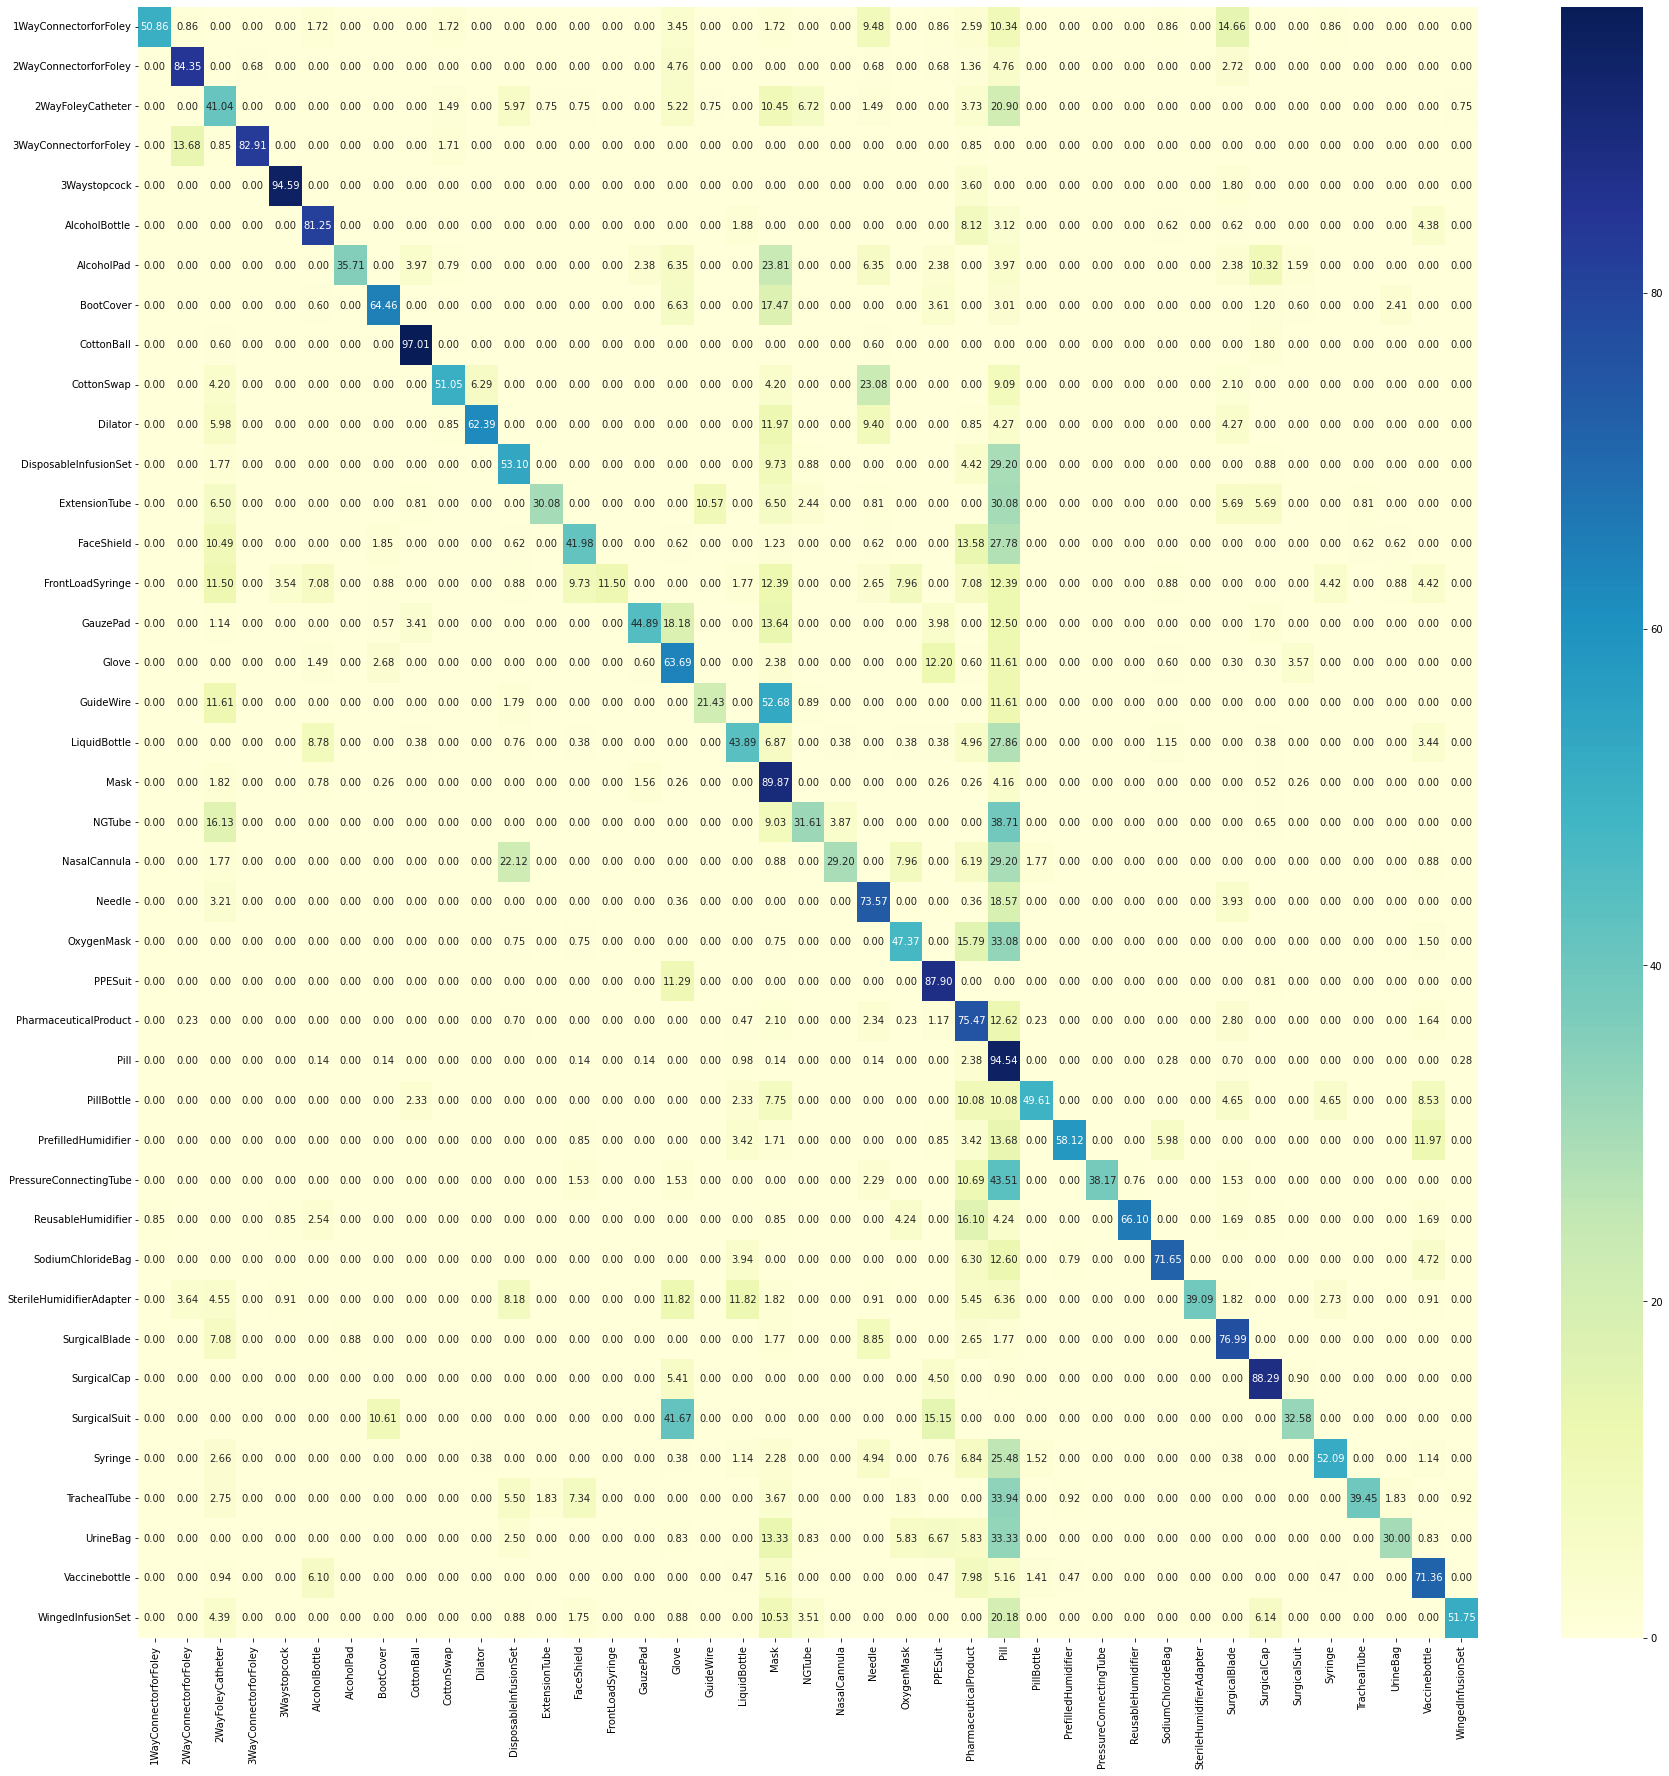

In [41]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")